# Classification of Text Data 

In  this project I implement a Multinomial Naive Bayes model to classify text data. Multinomial Naive Bayes works well for the following reasons:

- Handles high-dimensional data
- Robust to small datasets 
- Fast training and prediction 
- Works well for sparse data 
- Is an interpretable model 

### Import Statements

In [44]:
import spacy
import numpy as np 
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, auc

I use the following dataset: http://mlg.ucd.ie/datasets/bbc.html

In [2]:
# python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

### Note: 
Arrays are homogeneous (all elements are of the same type) while lists are heterogeneous(elements can be diifferent)

Arrays have a fixed size, whereas lists are dynamc 

Lists in python have more built in funtions 

In [3]:
# documents come in 5 folders, put them all together into one list 
files = sorted(list(Path('bbc').glob('**/*.txt')))
doc_list = [] 

for i,file in enumerate(files):
    # get folder name
    topic = file.parts[-2]
    article = file.read_text(encoding='latin1').split('\n')
    heading = article[0].strip()
    body = ' '.join([l.strip() for l in article[1:]])
    doc_list.append([topic, heading, body])

In [4]:
# create dataframe 
docs = pd.DataFrame(doc_list, columns=['topic','heading','body'])
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   topic    2225 non-null   object
 1   heading  2225 non-null   object
 2   body     2225 non-null   object
dtypes: object(3)
memory usage: 52.3+ KB


Here is a look into the data:

In [38]:
docs.sample(10)

,topic,heading,body
1123,politics,Labour pig poster 'anti-Semitic',The Labour Party has been accused of anti-Sem...
325,business,Senior Fannie Mae bosses resign,The two most senior executives at US mortgage...
1500,sport,Campbell lifts lid on United feud,Arsenal's Sol Campbell has called the rivalry...
1454,sport,Owen determined to stay in Madrid,England forward Michael Owen has told the BBC...
1298,politics,Voters 'don't trust politicians',Eight out of 10 voters do not trust politicia...
1633,sport,Woodward eyes Brennan for Lions,Toulouse's former Irish international Trevor ...
1006,politics,Kilroy launches 'Veritas' party,Ex-BBC chat show host and East Midlands MEP R...
1972,tech,Microsoft gets the blogging bug,Software giant Microsoft is taking the plunge...
302,business,Brazil plays down Varig rescue,The Brazilian government has played down clai...
454,business,Qantas considers offshore option,Australian airline Qantas could transfer as m...


In [42]:
docs.topic.value_counts(normalize=True).to_frame('count').style.format({'count': '{:,.2%}'.format})

,count
topic,
sport,22.97%
business,22.92%
politics,18.74%
tech,18.02%
entertainment,17.35%


The parameter  ` stratify = y` ensures that when the data is split into training and testing sets, the proportion of classes is preserved. 

without `stratify = y` there may be an unbalanced distributiion of classes between training and testing sets, especially if some classes are less frequent in the original dataset. 

with `stratify = y` the splot respected the distribution of the different classes in the dataset. 

For example, if topic 1 represents 20% of the original dataset, it will also represent approximately 20% of both the training and testing sets. 

In [5]:
# classify news articles

# create integer class values
y = pd.factorize(docs.topic)[0]
x = docs.body 
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=1,stratify=y)

### Vectorize Text Data

`CountVectorizer()` converts a collection of text documents into a matrix of token/word counts. First the data is tokenized by being split into individual words. Then, a vocabulary of unique tokens across the entire corpus is built. Finally, a word count matrix is created where each row corresponds to a document and each column corresponds to the count of a unique word in the vocabulary. 

In [32]:
vectorizer = CountVectorizer(stop_words=None)
x_train_dtm = vectorizer.fit_transform(x_train)
x_test_dtm = vectorizer.transform(x_test)

In [33]:
x_train_dtm.shape, x_test_dtm.shape

((1668, 25951), (557, 25951))

### Train Multi-Class Naive Bayes Model 

Naive Bayes is based on Bayes Theorem:

$ P(C|X) = \frac{P(X∣C)P(C)}{P(X)}$

where C is the class and X is the feature. 

Multinomial Naive Bayes:
- assumes features represent counts or frequencies 
- commonly used for text classification 
- likelihood is modeled using the multinomial distribution 

Some advantages of this model are its **simplicity, scalability, and probablistic output**. 

Some limitations are its **feature independence assumption** and its **zero frequency problem**. There is a strong assumption that features are condiditionally independent which does not always hold, depending on the data. Also, if a class has a zero probability for a given feature, the entire product becomes zero. 

Multinomial naive bayes handles frequency based features, making it effective for text classification when the number of times a word appears in an article is meaningful. 

My one concern while building this was that stop words would be frequent enough across all documents to influence the classification of topics. However, stop words are generally not topic-specific and do not provide much discriiminatory power between the classes. For example, the word "the" can appear in articles about both sports and politics. 

Naive Bayes is robust in this nature-- it naturall down weights stop words because of its probablistic nature. Stop words, being common across all classes, will have siimilar probabilities for all classes *((P(word|class))*. Thus, these words have limited impact on the overall classification decision 



In [34]:
nb = MultinomialNB()
nb.fit(x_train_dtm,y_train)
y_pred_class = nb.predict(x_test_dtm)

In [35]:
score = accuracy_score(y_test, y_pred_class)
print(score)

0.9712746858168761


Our model produces an accuracy score of 97% -- pretty good! 

### Create and plot confusion matrix

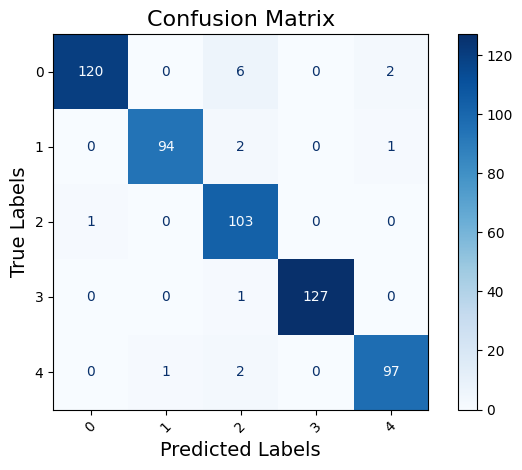

In [45]:
# calculate the confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_class)

# display the confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues', xticks_rotation=45)

# customize plot
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.show()


### Create ROC plot for all classes

In [25]:
y_pred_probs = nb.predict_proba(x_test_dtm)
# create binary labels for class 0
y_test_binary = (y_test == 0).astype(int)   
# probabilities for class 0
y_pred_probs_class0 = y_pred_probs[:, 0]     

/var/folders/7_/ynrwrkqd1l78np_skc5fbn9m0000gp/T/ipykernel_2712/3192755127.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


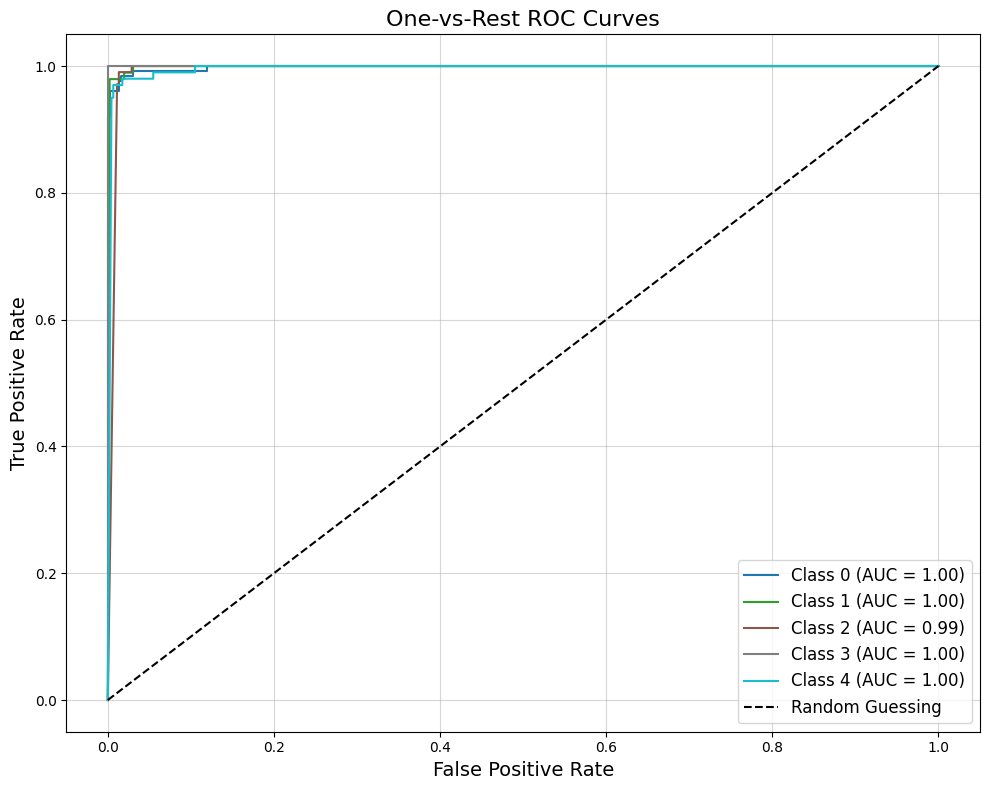

In [28]:
# get the unique class labels
classes = np.unique(y_test)  
n_classes = len(classes)

# binarize the output for multi-class ROC
y_test_binarized = label_binarize(y_test, classes=classes)

# initialize plot
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', n_classes)

# plot ROC for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {classes[i]} (AUC = {roc_auc:.2f})", color=colors(i))

# ddd diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")

# plot settings
plt.title("One-vs-Rest ROC Curves", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()